In [7]:
import at3d
import numpy as np
import os
import sys
import xarray as xr
from collections import OrderedDict
import pylab as py
path = '/Users/khargenr/AT3D/at3d'

In [8]:
#load the cloud.
cloud_scatterer = at3d.util.load_from_csv(os.path.join(path, './data/synthetic_cloud_fields/jpl_les/rico122x106x39.txt'),
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset(os.path.join(path, './data/ancillary/AFGL_summer_mid_lat.nc'))
#subset the atmosphere
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 10.0]})
#merge the atmosphere and cloud z coordinates
#merged_z_coordinate = at3d.grid.combine_z_coordinates([aerosol_scatterer, cloud_scatterer])

#make a merged grid for the rte.
rte_grid = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           cloud_scatterer.z)

In [9]:

# rte_grid = at3d.grid.make_grid(0.1, 10, 0.1, 10, merged_z_coordinate)
#resample the cloud onto the rte_grid
cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#define any necessary variables for microphysics here.
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


# Reconstruction MODIS + MISR

In [10]:
#define sensors.
sensor_resolution = 0.02
sensors_dict = at3d.containers.SensorsDict()
sensor_zenith_list =  [75.0,60.0,45.6,26.1]*2 + [0.0]
sensor_azimuth_list = [90]*4 + [-90]*4 +[0.0]
for zenith,azimuth in zip(sensor_zenith_list, sensor_azimuth_list):
    sensors_dict.add_sensor('MISR',
                    at3d.sensor.orthographic_projection(0.66, 
                                                           rte_grid, 
                                                           sensor_resolution, 
                                                           sensor_resolution,
                                                           azimuth, zenith,
                                                           altitude='TOA', stokes=['I'])
                           )
wavelengths = sensors_dict.get_unique_solvers()
min_stokes = sensors_dict.get_minimum_stokes()

In [11]:
#rayleigh optical properties if desired.
rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths, atmosphere, rte_grid)

In [12]:
solvers = at3d.containers.SolversDict()
cloud_poly_tables = OrderedDict()

for wavelength in wavelengths:
    mie_mono_table = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
    # print(wavelength)
    # #optical properties from mie calculations.
    # # Cloud
    # water_file = './mie_tables/mie_table_water_SWIR_%d.nc'%(wavelength*1e3)
    # try:
    #     mie_mono_table = xr.load_dataset(water_file)
    # except IOError:
    #     mie_mono_table = at3d.mie.get_mono_table(
    #         'Water', 
    #         (wavelength, wavelength),
    #         minimum_effective_radius=0.1,
    #     )
    #     mie_mono_table.to_netcdf(water_file, mode='w')
    cloud_size_distribution = at3d.size_distribution.get_size_distribution_grid(
        mie_mono_table.radius.data,
        size_distribution_function=at3d.size_distribution.gamma,
        particle_density=1.0,
        reff={'coord_min':.1,'coord_max':30.0,'npoints':30,'spacing':'linear','units':'micron'},
        veff={'coord_min':0.09,'coord_max':0.11,'npoints':2,'spacing':'linear','units':'unitless'},
    )
    poly_table = at3d.mie.get_poly_table(cloud_size_distribution, mie_mono_table)
    cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
    cloud_poly_tables[wavelength] = poly_table

    # Define solvers
    config = at3d.configuration.get_config()
    config['num_mu_bins'] = 8
    config['num_phi_bins'] = 16
    config['split_accuracy'] = 0.03
    config['spherical_harmonics_accuracy'] = 0 #.001
    config['solution_accuracy'] = 1e-4
    solvers.add_solver(
        wavelength, 
        at3d.solver.RTE(
            numerical_params=config,
            medium={
                'cloud': cloud_optical_scatterer,
                'rayleigh': rayleigh_scatterer_list[wavelength]
            },
            source=at3d.source.solar(wavelength, np.cos(np.deg2rad(60.0)), 0.0, solarflux=1.0),
            surface=at3d.surface.ocean_unpolarized(10.0, 0.0, delx=10.0, dely=10.0),
            num_stokes=min_stokes[wavelength],
            name=None
        )
    )

In [13]:
# get total OD
for wvl in wavelengths:
    sensor_od = sensors_dict['MISR']['sensor_list'][-1]
    solvers[wvl].optical_path(sensor_od)
    print('cloud OD @ %.3f nm ='%wvl, sensor_od.optical_path.data.mean())
    # get Rayleigh OD

cloud OD @ 0.660 nm = 0.8429704


In [14]:
#very important for the retrieval. the unknowns are visible extinction
#and reff not LWC and Reff. Much more orthogonal.
scaling_factor = cloud_poly_tables[0.66].extinction[:].copy(deep=True).data
#print(scaling_factor)
for wavelength in cloud_poly_tables:
    cloud_poly_tables[wavelength]['extinction'][:] /= scaling_factor

In [15]:
sensors_dict.get_measurements(solvers, n_jobs=8)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.698  0.331E+00   504348    10.76  0.168   [Radiance 0.660 micron]
     2  -1.562  0.371E+00   504348    10.76  0.168   [Radiance 0.660 micron]
     3  -1.900  0.386E+00   504348    10.76  0.168   [Radiance 0.660 micron]
     4  -2.154  0.183E+00   505392    10.87  0.170   [Radiance 0.660 micron]
     5  -2.466  0.101E+00   510996    11.43  0.179   [Radiance 0.660 micron]
     6  -2.587  0.576E-01   526872    12.88  0.201   [Radiance 0.660 micron]
     7  -2.684  0.394E-01   549449    14.81  0.231   [Radiance 0.660 micron]
     8  -2.765  0.301E-01   576548    16.94  0.265   [Radiance 0.660 micron]
     9  -3.086  0.300E-01   577806    17.04  0.266   [Radiance 0.660 micron]
    10  -3.415  0.304E-01   577806    17.04  0.266   [Radiance 0.660 micron]
    11  -3.638  0.304E-01   577806    17.04  0.266   [Radiance 0.660 micron]
    12  -3.787  0.304E-01   577806    17.04  0.266   [Radiance 0.660 micron]
  

In [16]:
def retrieve(uncertainty = 6e9, scale = 1.5e2):
    Sensordict = sensors_dict
    uncertainty = at3d.uncertainties.NullUncertainty('L2', uncertainty)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
                #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
    Sensordict.add_uncertainty_model('MISR', uncertainty)
    # uncertainty = at3d.uncertainties.RadiometricNoiseUncertainty(0, .001)
    # Sensordict.add_uncertainty_model('MISR', uncertainty)
    # Sensordict.add_noise('MISR')
    # Sensordict.add_uncertainty_model('MODIS', uncertainty)
    # Sensordict.add_noise('MODIS')
    forward_sensors = Sensordict.make_forward_sensors() # make a perfect copy of the sensor with the same subpixel rays.

    scale_reff = scale
    #scale_aerosol_density = 1e4

    wavelengths = forward_sensors.get_unique_solvers()

    mask = solvers[0.66].medium['cloud'].extinction.data > 0.0

    ext_profile = np.sum(solvers[0.66].medium['cloud'].extinction.data, axis=(0,1))
    CBH = rte_grid.z.data[np.where(ext_profile>0)[0][0]]
    CTH = rte_grid.z.data[np.where(ext_profile>0)[0][-1]]
    print(CBH, CTH)
    initial_cloud = xr.Dataset(
        data_vars={
            'density':(['x','y','z'], np.ones((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))),
            'reff': (['x','y','z'], np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+10.0),
            'veff':(['x','y','z'] ,np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+0.1)
        },
        coords=rte_grid.coords
    )

    #resample the cloud onto the rte_grid
    initial_cloud_on_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer_on_rte_grid.copy(deep=True))
    reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))

    def state_to_grid_density_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[mask] = state[1:]
        return state_on_grid

    def state_to_grid_reff_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[:,:,:] = state[0]*(rte_grid.z.data-0.44)**(1.0/3)/scale_reff #+state[1]/scale3
        state_on_grid[np.where(state_on_grid < 4.1)] = 4.1
        state_on_grid[np.where(np.isnan(state_on_grid))] = 4.1
        return state_on_grid

    solvers_reconstruct = at3d.containers.SolversDict()
    rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

    def set_state_fn(state):

        #update microphysics
        #aerosol_scatterer_on_rte_grid = initial_aerosol_on_grid.copy(deep=True)
        cloud_scatterer_on_rte_grid = initial_cloud_on_grid.copy(deep=True)

        cloud_scatterer_on_rte_grid['density'][:] = state_to_grid_density_cloud(state)
        cloud_scatterer_on_rte_grid['reff'][:] = state_to_grid_reff_cloud(state)
        #update optical properties
        for wavelength in wavelengths:
            poly_table = cloud_poly_tables[wavelength] #tables are used here.
            cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
            #cloud_optical_scatterer['extinction'][:] = state_to_grid_ext_cloud(state)
            
            #aerosol_poly_table = aerosol_poly_tables[wavelength]
            #aerosol_optical_scatterer = at3d.medium.table_to_grid(aerosol_scatterer_on_rte_grid, aerosol_poly_table)
            #aerosol_optical_scatterer['extinction'][:] = state_to_grid_ext_aerosol(state)      

    #         config = at3d.configuration.get_config('./default_config.json')
    #         config['num_mu_bins'] = 2
    #         config['num_phi_bins'] = 4
    #         config['split_accuracy'] = 0.1
    #         config['spherical_harmonics_accuracy'] = 0.001
    #         config['solution_accuracy'] = 1e-5
            solvers_reconstruct.add_solver(wavelength, at3d.solver.RTE(#numerical_params=config,
                                    numerical_params=solvers[wavelength].numerical_params,#config,
                                                    medium={'cloud': cloud_optical_scatterer,
                                                        'rayleigh': rayleigh_scatterer_list[wavelength]
                                                        },
                                                    source=solvers[wavelength].source,
                                                    surface=solvers[wavelength].surface,
                                                    num_stokes=solvers[wavelength]._nstokes,
                                                    name=None
                                                    )
                                    )

    # unknown_scatterers = at3d.containers.UnknownScatterers()
    # unknown_scatterers.add_unknown('cloud', ['density','reff'], cloud_poly_tables)
    # unknown_scatterers.create_derivative_tables()

    mie_mono_tables = OrderedDict()
    for wavelength in wavelengths:
        mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
            'Water',(wavelength,wavelength),
            max_integration_radius=65.0,
            minimum_effective_radius=0.1,
            relative_dir='../mie_tables',
            verbose=False
        )

    optical_property_generator = at3d.medium.OpticalPropertyGenerator(
        'cloud', 
        mie_mono_tables,
        at3d.size_distribution.gamma,
        density_normalization='geometric_extinction',
        reff=np.linspace(.1,30.0,30),
        veff=np.linspace(0.03,0.2,9),
    )

    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, cloud_optical_scatterer
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
            reff=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridProfile(mask=mask)),
            density=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridMask(mask=mask))
        #reff=(at3d.transforms.CoordinateTransform(), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
        )
    )

    def project_gradient_to_state(state, gradient):
        cloud_gradient = gradient.gradient.sel(variable_name='density',
                                            scatterer_name='cloud').data[mask]

        reff_gradient = gradient.gradient.sel(variable_name='reff',
                                            scatterer_name='cloud').where(mask, np.nan)
        
        reff_gradient1 = np.nansum(reff_gradient, axis=(0,1))*(rte_grid.z.data - 0.44)**(1.0/3)
        #reff_gradient2 = np.nansum(reff_gradient,axis=(0,1))

        full_grad = np.append(np.nansum(reff_gradient1)/scale_reff, cloud_gradient)
        
        #print some things here because I'm lazy.
        print('reff', state[0]/scale_reff , full_grad[0])
        print('cloud density avg.', np.mean(state[1:]), np.mean(full_grad[1:]))
        print('reff profile retrieve', state_to_grid_reff_cloud(state).mean(axis=(0,1)))
        print('reff profile true', reff_profile_true)
        return full_grad

    min_bound = np.zeros(1+np.sum(mask))+1e-5
    min_bound[0] = 1e-4*scale_reff

    max_bound = np.zeros(1+np.sum(mask))+199
    max_bound[0] = 29.9*scale_reff

    obj_fun = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        Sensordict, 
        solvers_reconstruct,
        forward_sensors,
        unknown_scatterers,
        set_state_fn,
        project_gradient_to_state,
        #exact_single_scatter=False,
        parallel_solve_kwargs={'n_jobs': 4, 'mpi_comm':None,
                                    'verbose':False, 'maxiter':100, 'init_solution':True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':False},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bound,
        max_bounds=max_bound
    )

    # initial guess
    x0_reff = 10
    x0_ext_cloud = 10
    x0 = np.append(np.array([x0_reff*scale_reff]), x0_ext_cloud*np.ones(np.sum(mask)))
    print(x0)
    print(state_to_grid_reff_cloud(x0).mean(axis=(0,1)))
    optimizer = at3d.optimize.Optimizer
    optimizer = at3d.optimize.Optimizer
    optimizer.options

    #define optimizer (no prior function)
    optimizer = at3d.optimize.Optimizer(obj_fun)#, prior_fn=prior_func)
    optimizer._options['maxls'] = 8
    optimizer._options['maxiter'] = 20 #maxiter to 1 to debug the saving of result.
    #optimize for the specified initial condition.
    result = optimizer.minimize(x0)
    return solvers_reconstruct[.66].medium['cloud'].reff.data.max(), np.nanmean(solvers_reconstruct[.66].medium['cloud'].density.data[mask])

In [17]:
uncertainties = np.exp(np.arange(.5, 1.5, .5))*6e9
print(uncertainties)
scales = np.exp(np.arange(1, 3.1, 1))*150
print(scales)

[9.89232762e+09 1.63096910e+10]
[ 407.74227427 1108.35841484 3012.83053848]


In [18]:
%%time
reff_2d = []
density_2d = []
count = 0
for i in uncertainties:
    reff_1d = []
    density_1d = []
    for j in scales:
        count += 1
        print(str(count) + " out of " + str(len(uncertainties)*len(scales)))
        print("------uncertainty", i, "scale", j, "-------")
        reff, density = retrieve(i, j)
        reff_1d.append(reff)
        density_1d.append(density)
    reff_2d.append(reff_1d)
    density_2d.append(density_1d)

rounded_uncertainties = np.round(uncertainties, 1)
rounded_scales = np.round(scales, 1)
img = py.imshow(reff_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()

img = py.imshow(density_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()


1 out of 6
------uncertainty 9892327624.20077 scale 407.74227426885676 -------
0.52 1.72


/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_35387/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[4077.42274269   10.           10.         ...   10.           10.
   10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff 10.0 38.073605916606994
cloud density avg. 10.0 -3.8066998083823393
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.38

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_35387/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[1.10835841e+04 1.00000000e+01 1.00000000e+01 ... 1.00000000e+01
 1.00000000e+01 1.00000000e+01]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff 10.0 14.0064968679831
cloud density avg. 10.0 -3.8066998083823393
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_35387/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[3.01283054e+04 1.00000000e+01 1.00000000e+01 ... 1.00000000e+01
 1.00000000e+01 1.00000000e+01]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff 10.0 5.152702240563181
cloud density avg. 10.0 -3.8066998083823393
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.2

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_35387/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[4077.42274269   10.           10.         ...   10.           10.
   10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff 10.0 62.77276392696418
cloud density avg. 10.0 -6.276186945250063
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_35387/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[1.10835841e+04 1.00000000e+01 1.00000000e+01 ... 1.00000000e+01
 1.00000000e+01 1.00000000e+01]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.25985568 10.3849882  10.50717574
 10.62658569 10.74337071 10.85767047 10.9696131  11.07931651 11.18688942
 11.29243235 11.39603843 11.49779416]
reff 10.0 23.092809314238455
cloud density avg. 10.0 -6.276186945250063
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.         10.13159404 10.2

KeyboardInterrupt: 

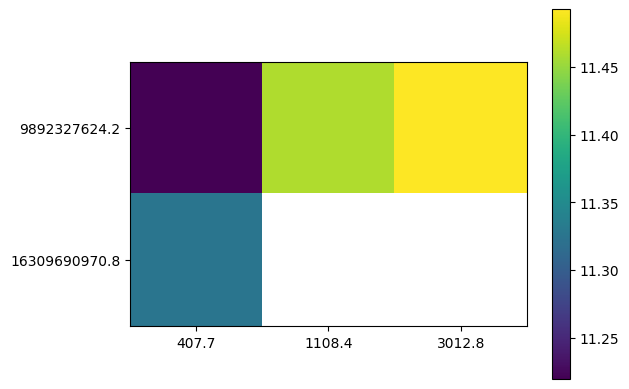

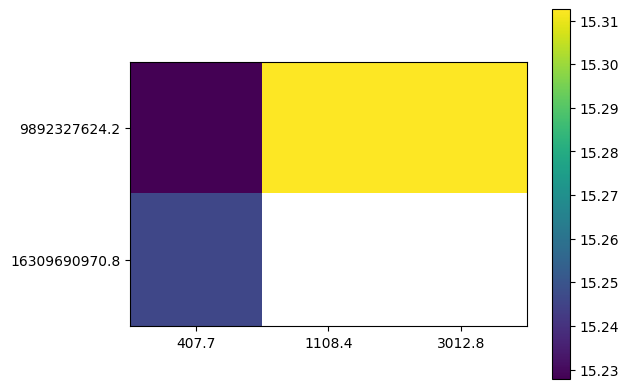

In [34]:
rounded_uncertainties = np.round(uncertainties, 1)
rounded_scales = np.round(scales, 1)
img = py.imshow(reff_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()

img = py.imshow(density_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()